# Primeiro modelo: fazendo exploração e criando primeira árvore de decisão

Na etapa anterior, geramos o arquilo excel (o csv gerado ficava corrompido) com dados selecionados da extração de features de cada página de vídeo. Foi criada a coluna y na planilha, onde foram adicionadas labels para 503 registros, da seguinte forma:
* 0: Vídeo não despertou o interesse em assistir
* 1: Houve interesse em assistir ao vídeo

A consideração para criar a label se baseou no título do vídeo e na quantidade de views. Para criar as labels para os demais dados, será aplicada uma técnica de active learning.

In [1]:
#importando pacotes
import pandas as pd
import numpy as np
import re
import time

import bs4
import json

import glob
import tqdm

pd.set_option("max.columns", 100)

#https://strftime.org
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_excel('./datasets/raw_data_with_labels.xlsx', index_col=0)

In [3]:
df.head()

,watch-title,y,watch-view-count,watch-time-text,watch7-headline,watch8-sentiment-actions,og:image,og:image:width,og:description,og:video:width,og:video:height,og:video:tag,content_watch-info-tag-list,channel_link_0
0,Finanças é Coisa de Criança!,0.0,635 visualizações,Publicado em 30 de jul. de 2019,#intusforma #institucional #educacao\n\n\n\n ...,635 visualizações\n\n\n\n\nGostou deste vídeo?...,https://i.ytimg.com/vi/-0HZcKmHXn4/maxresdefau...,1280.0,Um dos nossos primeiros programas que deram vi...,1280.0,720.0,financasecoisadecrianca,Educação,/channel/UCjE76zhvoDw5hnLtmzFHR-Q
1,Câncer 2020 - Profissional e Finanças 1° semestre,0.0,37.305 visualizações,Publicado em 3 de dez. de 2019,#tarô #previsão2020 #profissional2020\n\n\n\n ...,37.305 visualizações\n\n\n\n\n\n\n\n2.550\n\nG...,https://i.ytimg.com/vi/-1kS-ZrfcYQ/hqdefault.jpg,480.0,Previsão primeiro semestre de 2020 profissiona...,1280.0,720.0,tarot câncer 2020 profissional,Pessoas e blogs,/channel/UCL6feH5A7tjCoNTKAkJ9ITQ
2,Seja Rica: Conquiste sua Independência Financeira,0.0,98 visualizações,Publicado em 30 de mar. de 2017,Seja Rica: Conquiste sua Independência Financeira,98 visualizações\n\n\n\n\n\n\n\n29\n\nGostou d...,https://i.ytimg.com/vi/-40s-kunvQM/hqdefault.jpg,480.0,Seja Rica é o novo quadro aqui do canal. Nesse...,640.0,360.0,Rico,Pessoas e blogs,/channel/UChgFe4WPc8Wx4tJVAdd9-rA
3,Independência FINANCEIRA,0.0,41 visualizações,Publicado em 19 de mar. de 2019,Independência FINANCEIRA,41 visualizações\n\n\n\n\n\n\n\n17\n\nGostou d...,https://i.ytimg.com/vi/-6dz-10LkHc/maxresdefau...,1280.0,"Como conseguir sua independência financeira, m...",1280.0,720.0,pouco,Pessoas e blogs,/channel/UCUH-FVOIrY6IW2hs66A4IFA
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#criando dataframe somente os registros que foram etiquetados.
df_labeled = df[df.y.notnull()].copy()

In [5]:
df_labeled.shape

(503, 14)

In [6]:
#temos 503 registros etiquetados
df_labeled.head()

,watch-title,y,watch-view-count,watch-time-text,watch7-headline,watch8-sentiment-actions,og:image,og:image:width,og:description,og:video:width,og:video:height,og:video:tag,content_watch-info-tag-list,channel_link_0
0,Finanças é Coisa de Criança!,0.0,635 visualizações,Publicado em 30 de jul. de 2019,#intusforma #institucional #educacao\n\n\n\n ...,635 visualizações\n\n\n\n\nGostou deste vídeo?...,https://i.ytimg.com/vi/-0HZcKmHXn4/maxresdefau...,1280.0,Um dos nossos primeiros programas que deram vi...,1280.0,720.0,financasecoisadecrianca,Educação,/channel/UCjE76zhvoDw5hnLtmzFHR-Q
1,Câncer 2020 - Profissional e Finanças 1° semestre,0.0,37.305 visualizações,Publicado em 3 de dez. de 2019,#tarô #previsão2020 #profissional2020\n\n\n\n ...,37.305 visualizações\n\n\n\n\n\n\n\n2.550\n\nG...,https://i.ytimg.com/vi/-1kS-ZrfcYQ/hqdefault.jpg,480.0,Previsão primeiro semestre de 2020 profissiona...,1280.0,720.0,tarot câncer 2020 profissional,Pessoas e blogs,/channel/UCL6feH5A7tjCoNTKAkJ9ITQ
2,Seja Rica: Conquiste sua Independência Financeira,0.0,98 visualizações,Publicado em 30 de mar. de 2017,Seja Rica: Conquiste sua Independência Financeira,98 visualizações\n\n\n\n\n\n\n\n29\n\nGostou d...,https://i.ytimg.com/vi/-40s-kunvQM/hqdefault.jpg,480.0,Seja Rica é o novo quadro aqui do canal. Nesse...,640.0,360.0,Rico,Pessoas e blogs,/channel/UChgFe4WPc8Wx4tJVAdd9-rA
3,Independência FINANCEIRA,0.0,41 visualizações,Publicado em 19 de mar. de 2019,Independência FINANCEIRA,41 visualizações\n\n\n\n\n\n\n\n17\n\nGostou d...,https://i.ytimg.com/vi/-6dz-10LkHc/maxresdefau...,1280.0,"Como conseguir sua independência financeira, m...",1280.0,720.0,pouco,Pessoas e blogs,/channel/UCUH-FVOIrY6IW2hs66A4IFA
5,6 ERROS para NÃO ter a INDEPENDÊNCIA FINANCEIR...,0.0,389 visualizações,Publicado em 21 de jan. de 2020,6 ERROS para NÃO ter a INDEPENDÊNCIA FINANCEIR...,389 visualizações\n\n\n\n\n\n\n\n86\n\nGostou ...,https://i.ytimg.com/vi/-CcyxsGoquk/maxresdefau...,1280.0,"Ano novo, vida financeira nova! A partir de ag...",1280.0,720.0,não ter independência financeira,Educação,/channel/UCu8nmn2Na1wcPUxy7dDqG2A


In [7]:
df_labeled.tail()

,watch-title,y,watch-view-count,watch-time-text,watch7-headline,watch8-sentiment-actions,og:image,og:image:width,og:description,og:video:width,og:video:height,og:video:tag,content_watch-info-tag-list,channel_link_0
531,"Selic em Queda, mais um corte. Onde investir? ...",0.0,9.146 visualizações,Transmitido ao vivo em 6 de mai. de 2020,#Selic #Queda #Corte\n\n\n\n Selic em Queda...,9.146 visualizações\n\n\n\n\n\n\n\n1.071\n\nGo...,https://i.ytimg.com/vi/KrbfULnm2C8/maxresdefau...,1280.0,"Selic em queda, de novo? E agora quem poderá n...",1280.0,720.0,inflação,Entretenimento,/channel/UCkvpo9jvRG73j7iCBTNL-OA
532,🔴 O Que é CDI? Taxa CDI? Investir em CDI? - En...,1.0,314.473 visualizações,Publicado em 23 de set. de 2016,🔴 O Que é CDI? Taxa CDI? Investir em CDI? - En...,314.473 visualizações\n\n\n\n\n\n\n\n22.241\n\...,https://i.ytimg.com/vi/KuoeirjSEUg/maxresdefau...,1280.0,Você sabe O que É CDI? Você já ouviu alguma ve...,1280.0,720.0,primo rico cdi,Entretenimento,/channel/UCT4nDeU5pv1XIGySbSK-GgA
533,O Melhor Aplicativo de Finanças do MUNDO,0.0,3.719 visualizações,Publicado em 19 de nov. de 2019,O Melhor Aplicativo de Finanças do MUNDO,3.719 visualizações\n\n\n\n\n\n\n\n184\n\nGost...,https://i.ytimg.com/vi/KyOiaLtfDMY/maxresdefau...,1280.0,Nesse vídeo você vai conhecer o melhor aplicat...,1280.0,720.0,aplicativo minhas economias como usar,Educação,/channel/UCyCBeQuIVG09fgcNIEsYJgA
534,INDEPENDÊNCIA FINANCEIRA: como calcular o valo...,0.0,214 visualizações,Transmitido ao vivo em 10 de mai. de 2019,#rotadariqueza #independênciafinanceira #horad...,214 visualizações\n\n\n\n\n\n\n\n27\n\nGostou ...,https://i.ytimg.com/vi/KzJyRYs9_RE/hqdefault.jpg,480.0,Já parou para calcular quanto você precisa acu...,NaN,NaN,quanto juntar,Educação,/channel/UCGEgCjRA7BElVTOCCMciQyg
535,"Live: Independência financeira, realidade ou u...",0.0,1.283 visualizações,Transmitido ao vivo em 24 de out. de 2018,"Live: Independência financeira, realidade ou u...",1.283 visualizações\n\n\n\n\n\n\n\n132\n\nGost...,https://i.ytimg.com/vi/L1xLg9ktipE/maxresdefau...,1280.0,Acompanhe a primeira live semanal do Dinheiram...,1280.0,720.0,ganhardinheiro,Educação,/channel/UCrRY-awCDpGJZxJ4JxQG-AA


A partir de agora, serão feitas algumas etapas de transformação no dataframe com labels, para criar um novo conjunto de dados com atributos em formado adequado para criar o modelo de active learning.

In [8]:
#criando dataframe com os índices do df_labeled
df_limpo = pd.DataFrame(index = df_labeled.index)

In [9]:
df_limpo.head()

""
0
1
2
3
5


## 1 - Coletando a data de publicação em formato datetime

Queremos obter a data de publicação de cada vídeo no formato dd-mm-aaaa, conforme orientado pelo Mário Filho durante o curso.

In [10]:
#formato da data de publicação no dataframe com labels:
df_labeled['watch-time-text'].head()

0    Publicado em 30 de jul. de 2019
1     Publicado em 3 de dez. de 2019
2    Publicado em 30 de mar. de 2017
3    Publicado em 19 de mar. de 2019
5    Publicado em 21 de jan. de 2020
Name: watch-time-text, dtype: object

In [11]:
map_mes = {'jan.':'Jan',
             'fev.':'Feb',
              'mar.':'Mar',
              'abr.':'Apr',
              'mai.':'May',
              'jun.':'Jun',
              'jul.':'Jul',
              'ago.':'Aug',
              'set.':'Sep',
              'out.':'Oct',
              'nov.':'Nov',
              'dez.':'Dec'}

In [12]:
def limpa_data (row):
    #data_limpa = row.loc['watch-time-text'].extract(r"(\d+) de ([a-z]+)\. de (\d+)") #recuperando as informações de dia, mês e ano da string
    data_limpa = re.search(r"(\d+) de ([a-z]+)\. de (\d+)", row.loc['watch-time-text']).group()
    data_limpa = data_limpa.split('de ')
    data_limpa = [x.strip() for x in data_limpa]
    data_limpa[0] = ['0' + str(data_limpa[0]) if len(data_limpa[0]) == 1 else data_limpa[0]][0]
    data_limpa[1] = [v for k, v in map_mes.items() if k == data_limpa[1]][0]
    data = '-'.join(data_limpa)

    return data

In [13]:
limpa_data(df_labeled.loc[1])

'03-Dec-2019'

In [14]:
df_labeled['data'] = df_labeled.apply(limpa_data, axis=1)

In [15]:
df_labeled.data

0      30-Jul-2019
1      03-Dec-2019
2      30-Mar-2017
3      19-Mar-2019
5      21-Jan-2020
          ...     
531    06-May-2020
532    23-Sep-2016
533    19-Nov-2019
534    10-May-2019
535    24-Oct-2018
Name: data, Length: 503, dtype: object

In [16]:
df_labeled['data'] = pd.to_datetime(df_labeled['data'])

In [17]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 535
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   watch-title                  503 non-null    object        
 1   y                            503 non-null    float64       
 2   watch-view-count             495 non-null    object        
 3   watch-time-text              503 non-null    object        
 4   watch7-headline              503 non-null    object        
 5   watch8-sentiment-actions     499 non-null    object        
 6   og:image                     503 non-null    object        
 7   og:image:width               503 non-null    float64       
 8   og:description               503 non-null    object        
 9   og:video:width               501 non-null    float64       
 10  og:video:height              501 non-null    float64       
 11  og:video:tag                 435 non-null    

## Fazendo limpeza no campo com número de visualizações
Nessa etapa, queremos obter o número de visualizações como um inteiro em uma nova coluna

In [18]:
#coluna com informação de views
df['watch-view-count'].head()

0       635 visualizações
1    37.305 visualizações
2        98 visualizações
3        41 visualizações
4                     NaN
Name: watch-view-count, dtype: object

In [19]:
#adicionando coluna com view count formatado
df_labeled['views'] = df['watch-view-count'].str.extract(r"(\d+\.?\d*)", expand=False).str.replace(".","").fillna(0).astype(int)

In [20]:
df_labeled.views.head()

0      635
1    37305
2       98
3       41
5      389
Name: views, dtype: int32

In [21]:
df_limpo = df_labeled[['data', 'views']]

In [22]:
df_limpo.head()

,data,views
0,2019-07-30,635
1,2019-12-03,37305
2,2017-03-30,98
3,2019-03-19,41
5,2020-01-21,389


In [23]:
df_labeled.head()

,watch-title,y,watch-view-count,watch-time-text,watch7-headline,watch8-sentiment-actions,og:image,og:image:width,og:description,og:video:width,og:video:height,og:video:tag,content_watch-info-tag-list,channel_link_0,data,views
0,Finanças é Coisa de Criança!,0.0,635 visualizações,Publicado em 30 de jul. de 2019,#intusforma #institucional #educacao\n\n\n\n ...,635 visualizações\n\n\n\n\nGostou deste vídeo?...,https://i.ytimg.com/vi/-0HZcKmHXn4/maxresdefau...,1280.0,Um dos nossos primeiros programas que deram vi...,1280.0,720.0,financasecoisadecrianca,Educação,/channel/UCjE76zhvoDw5hnLtmzFHR-Q,2019-07-30,635
1,Câncer 2020 - Profissional e Finanças 1° semestre,0.0,37.305 visualizações,Publicado em 3 de dez. de 2019,#tarô #previsão2020 #profissional2020\n\n\n\n ...,37.305 visualizações\n\n\n\n\n\n\n\n2.550\n\nG...,https://i.ytimg.com/vi/-1kS-ZrfcYQ/hqdefault.jpg,480.0,Previsão primeiro semestre de 2020 profissiona...,1280.0,720.0,tarot câncer 2020 profissional,Pessoas e blogs,/channel/UCL6feH5A7tjCoNTKAkJ9ITQ,2019-12-03,37305
2,Seja Rica: Conquiste sua Independência Financeira,0.0,98 visualizações,Publicado em 30 de mar. de 2017,Seja Rica: Conquiste sua Independência Financeira,98 visualizações\n\n\n\n\n\n\n\n29\n\nGostou d...,https://i.ytimg.com/vi/-40s-kunvQM/hqdefault.jpg,480.0,Seja Rica é o novo quadro aqui do canal. Nesse...,640.0,360.0,Rico,Pessoas e blogs,/channel/UChgFe4WPc8Wx4tJVAdd9-rA,2017-03-30,98
3,Independência FINANCEIRA,0.0,41 visualizações,Publicado em 19 de mar. de 2019,Independência FINANCEIRA,41 visualizações\n\n\n\n\n\n\n\n17\n\nGostou d...,https://i.ytimg.com/vi/-6dz-10LkHc/maxresdefau...,1280.0,"Como conseguir sua independência financeira, m...",1280.0,720.0,pouco,Pessoas e blogs,/channel/UCUH-FVOIrY6IW2hs66A4IFA,2019-03-19,41
5,6 ERROS para NÃO ter a INDEPENDÊNCIA FINANCEIR...,0.0,389 visualizações,Publicado em 21 de jan. de 2020,6 ERROS para NÃO ter a INDEPENDÊNCIA FINANCEIR...,389 visualizações\n\n\n\n\n\n\n\n86\n\nGostou ...,https://i.ytimg.com/vi/-CcyxsGoquk/maxresdefau...,1280.0,"Ano novo, vida financeira nova! A partir de ag...",1280.0,720.0,não ter independência financeira,Educação,/channel/UCu8nmn2Na1wcPUxy7dDqG2A,2020-01-21,389


### Criação de features

Agora, com as transformações feitas anteriormente, será possível criar algumas features para treinar um modelo inicial e tentar extraír algumas conclusões sobre a previsão. Ja temos o número de views de cada vídeo e a data de publicação. A nova feature a ser criada será o número de views por dia. Para isso, vamos usar como referência o dia seguinte à data de coleta dos dados, que foi 07-Maio-2020.

In [24]:
# criando dataframe para as features:
features = pd.DataFrame(index=df_limpo.index)

In [25]:
#criando série com as labels
y = df_labeled['y'].copy()

In [26]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
5    0.0
Name: y, dtype: float64

In [51]:
#criando coluna com dias que se passaram desde a publicação até a data referência
features['dias_publicado'] = (pd.to_datetime("2020-05-08") - df_limpo['data']) / np.timedelta64(1, 'D') 
#denominador cria um objeto timedelta do numpy em diferença de 1 dia

In [52]:
features.head()

,views,views_por_dia,dias_publicado
0,635,2.251773,283.0
1,37305,239.134615,157.0
2,98,0.086420,1135.0
3,41,0.098795,416.0
5,389,3.635514,108.0


In [53]:
#adicionando a coluna de views ao dataframe features
features['views'] = df_limpo['views']

In [54]:
features.head()

,views,views_por_dia,dias_publicado
0,635,2.251773,283.0
1,37305,239.134615,157.0
2,98,0.086420,1135.0
3,41,0.098795,416.0
5,389,3.635514,108.0


O total de dias após publicação não retrata a popularidade do vídeo, já que um vídeo pode ter acumulado muitas visualizações ao longo do tempo, enquanto um outro pode ter tido várias views em pouco tempo. Por isso, será criada agora a feature views por dia:

In [55]:
features['views_por_dia'] = features['views']/features['dias_publicado']

In [56]:
features.head()

,views,views_por_dia,dias_publicado
0,635,2.243816,283.0
1,37305,237.611465,157.0
2,98,0.086344,1135.0
3,41,0.098558,416.0
5,389,3.601852,108.0


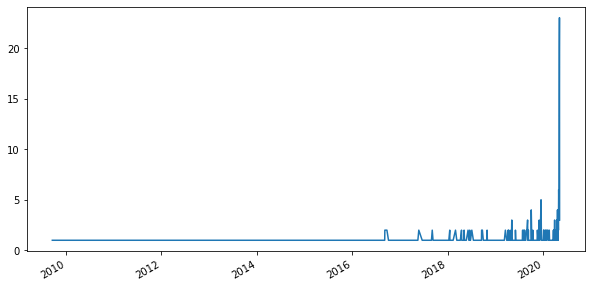

In [57]:
#vamos visualizar a distribuição da quantidade de vídeos publicados sobre o tema Finanças ao longo do tempo, na nossa amostra:
df_limpo['data'].value_counts().plot(figsize=(10, 5))

Como vemos no gráfico acima, a maioria dos vídeos na amostra foi publicada a partir de 2016. Como usamos o filtro de *Relevância* do youtube, pessoalmente, eu atribuo essa concentração de vídeos relevantes como sendo os mais recentes devido à popularização do tema **Educação Financeira** nos últimos 2 anos, e o consequente aumento de mais conteúdo sobre o tema, a fim de ganhar visualizações. Assim, antes de dividir o conjunto de dados em treino e validação, vou filtrar o dataframe com vídeos publicados somente a partir de 2018 para realizar algumas análises.

In [58]:
#quantidade de vídeos publicada a partir de 2018 na amostra
df_limpo[df_limpo.data >= '2018-01-01'].data.count()


404

In [59]:
#quantidade de vídeos publicada antes de 2018 na amostra
df_limpo[df_limpo.data < '2018-01-01'].data.count()

99

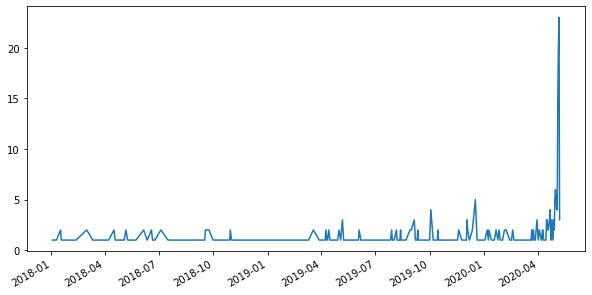

In [60]:
#plotando gráfico para vídeos após 2018
df_limpo[df_limpo.data >= '2018-01-01'].data.value_counts().plot(figsize=(10, 5))

Aqui podemos ver que a maioria dos videos ainda possui data de publicação muito próxima à data da coleta. Isso deve ao filtro para *videos mais relevantes* que foi utilizado. É natural que a maioria deles sejam os mais recentes, por estarem em alta no youtube. Nesse momento, não irei refazer a extração de dados, mas é preciso ter ciência de que o modelo será viesado para vídeos mais recentes **Aceito opiniões/explicações contrárias e construtivas aqui. Estou aprendendo...**

In [61]:
## criando dataframe com dados a partir de 2018
df_2018_up = df_limpo[df_limpo.data >= '2018-01-01']

In [62]:
df_2018_up.head()

,data,views
0,2019-07-30,635
1,2019-12-03,37305
3,2019-03-19,41
5,2020-01-21,389
6,2019-04-14,129


Vamos visualizar o número de views para as datas de publicação nos vídeos publicados antes e partir de 2018.

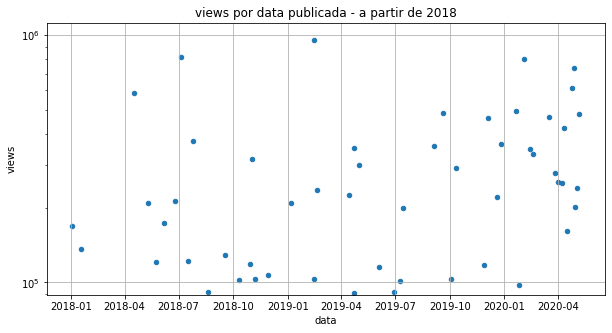

In [63]:
df_2018_up.plot(kind='scatter', x = 'data', y = 'views', grid=True, figsize=(10, 5), logy = True, title='views por data publicada - a partir de 2018')

No gráfico de dispersão acima, é possível ver que os vídeos mais recentes acumulam visualizações da ordem de centenas de milhares em sua maioria. Abaixo está plotada a dispersão para vídeos publicados até 31-12-2017:

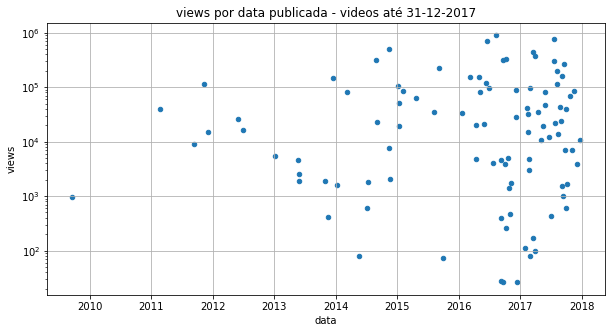

In [64]:
df_limpo[df_limpo.data < '2018-01-01'].plot(kind='scatter', x = 'data', y = 'views', grid=True, figsize=(10, 5), logy = True, title='views por data publicada - videos até 31-12-2017')

Podemos ver aqui que os vídeos anteriores a 2018 apresentam uma faixa maior de visualizações, com alguns contendo menos de 1000 views. Existe também uma concentração de publicações entre 2016 e 2018, a qual eu atribuo ao início do movimento de educação financeira no Brasil, que mesmo não tão difundido, já era expressivo. Como a intenção é gerar um modelo inicial simples, vamos dar seguimento com o treino sem modificar o dataset de trabalho, que será o dataframe *features*, sem os dados de dias de publicação, já que ao dividir os dados para treino e validação, um video publicado a um número de dias de um lado da divisão nunca aparecerá no conjunto de dados do outro lado da divisão.

In [65]:
features = features.drop('dias_publicado', axis = 1)
features.head()

,views,views_por_dia
0,635,2.243816
1,37305,237.611465
2,98,0.086344
3,41,0.098558
5,389,3.601852


Como temos uma amostra com a grande maioria dos exemplos próxima da data da coleta, para separar os dados em treino e validação em 50%, vamos utilizar a data do quantil 0.5:

In [66]:
df_limpo.data.quantile(0.5)

Timestamp('2019-07-29 00:00:00')

In [67]:
#importando alguns modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [68]:
Xtrain, Xval = features[df_limpo.data < df_limpo.data.quantile(0.5)], features[df_limpo.data >= df_limpo.data.quantile(0.5)]
ytrain, yval = y[df_limpo.data < df_limpo.data.quantile(0.5)], y[df_limpo.data >= df_limpo.data.quantile(0.5)]

In [69]:
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((250, 2), (253, 2), (250,), (253,))

In [70]:
# número de exemplos positivos na amostra de treino
ytrain.mean() * 250

79.0

In [71]:
#(seguindo orientações do curso)
#verificando como as duas features selecionadas influenciam a indicação de vídeos de interesse
mdl = DecisionTreeClassifier(random_state=28, max_depth=2, class_weight="balanced") #class_weight balanced vai penalizar o modelo quando ele errar exemplos positivos, dado o desbalanceamento da classe
mdl.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=28)

Tip: Criar uma árvore de decisão é uma boa maneira de entender a relação de poucas features com a previsão

In [72]:
p = mdl.predict_proba(Xval)[:, 1] #função predict_proba gera dois numpy arrays com as probabilidades de casa caso serem 0 e 1
# queremos somente a probabilidade de ser 1

In [73]:
#importanto métricas
from sklearn.metrics import roc_auc_score, average_precision_score

average_precision: É área sob a curva do gráfico precision x recall para cada ponto de corte que poderia ser escolhido para as previsões. Mais [aqui](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py).


In [74]:
average_precision_score(yval, p)

0.466503359462486

interpretando o resultado acima: Será adotada a baseline de 0.467

In [75]:
roc_auc_score(yval, p)

0.8083843329253366

mais sobre **roc_auc_score** [aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [76]:
#plotando a árvore de decisão
from sklearn.tree import plot_tree

[Text(279.0, 453.0, 'views <= 31228.0\ngini = 0.5\nsamples = 250\nvalue = [125.0, 125.0]'),
 Text(139.5, 271.8, 'views_por_dia <= 1.545\ngini = 0.35\nsamples = 160\nvalue = [103.07, 30.063]'),
 Text(69.75, 90.59999999999997, 'gini = 0.0\nsamples = 50\nvalue = [36.55, 0.0]'),
 Text(209.25, 90.59999999999997, 'gini = 0.429\nsamples = 110\nvalue = [66.52, 30.063]'),
 Text(418.5, 271.8, 'views_por_dia <= 76.027\ngini = 0.305\nsamples = 90\nvalue = [21.93, 94.937]'),
 Text(348.75, 90.59999999999997, 'gini = 0.478\nsamples = 29\nvalue = [12.427, 18.987]'),
 Text(488.25, 90.59999999999997, 'gini = 0.198\nsamples = 61\nvalue = [9.503, 75.949]')]

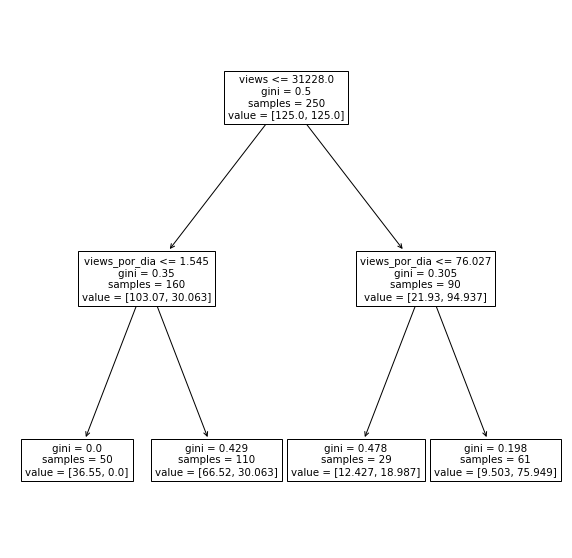

In [78]:
fig, ax  = pylab.subplots(1,1, figsize=(10, 10))
plot_tree(mdl, ax=ax, feature_names=Xtrain.columns)

Interpretando a árvore de decisão (definindo níveis: 1, 2, e 3, de cima para baixo):

- No nível 1, temos a delimitação feita pela árvora, para vídeos com até 31228 views e views acima desse valor. Ao descer pela árvore, os nós no lado esquerdo são o próximo nível para quando a condição no nó anterior é verdadeira. o vetor **value** indica o peso de cada classe na amostra, sendo o lado esquerdo para o valor negativo, e o direito para o positivo (ainda que não tenhamos o mesmo tamanho de amostra para cada classe no nível 1 da árvore, o parâmetro "balanced" pondera as amostras para que tenham o mesmo peso.  

- No nível 2, lado esquerdo, temos a condição para quando views <= 31228. Agora, a árvore está analisando a feature views_por_dia. para vídeos com menos de 1.5 views por dia, temos como verdadeiro o primeiro nó no nível 3. Nesse nó, temos 50 amostras, sendo todas negativas  (vetor value com a segunda posição igual a 0.0). Nesse nó, estão todos os exemplos negativos que realmente são negativos.

- No segundo nó do nível 2, estão as amostras para a feature views_por_dia > 1.545. Nesse nível, temos 110 amostra, com o vetor value indicado a presenta de mais amostras negativas, ou seja, de vídeos que provavelmente não irei ter interesse em assistir. Nesse lado da árvore, parecem estar os vídeos menos populares (menos views no total e menos views por dia).

- Indo para o lado direito da árvore, no nível 2 estão as amostras para quando o número de views é maior que 31228. esse nó divide as amostras entre as que tem até 76027 views por dia, e as que tem valor dessa feature maior que esse threshold. Descendo a partir desse nó pelo lado esquerdo, chega-se ao 3º nó do nível 3. Esse nó indica que há 29 amostras com views > 31228 e views_por_dia <= 76027. Aqui, o peso das amostras positivas é cerca de 50% maior que o das negativas, indicando que dos vídeos nessa faixa, há mais que são de interesse do que vídeos que não são.

- Por fim, indo para o 4º nó do nível 3, temos as amostras para os vídeos com mais de 31228 views e mais de 76027 views por dia. Aqui, 61 amostras possuem maior peso positivo (75,949), indicando que meu interesse está nos vídeos mais populares (com mais views e mais views por dia). Para calcular a previsão nesse nó, e nos demais, bastaria dividir o valor da posição 2 do vetor pela soma das duas posições (no nível 4, 75,949/(9,503 + 75,949) = 0,889).

Lembrar que aqui, a árvore é simples, com apenas 2 níveis e poucas features. Serve apenas para conclusões iniciais. De todo modo, a árvore deixou claro a preferência por vídeos mais populares.

Esse notebook será encerrado aqui, e um novo será criado para a etapa de active learning, onde será criado um novo modelo para criar labels para as demais amostras do conjunto de dados que foi parcialmente etiquetado, para que se tenha um número maior de amostras para treinar o modelo final. Os dataframes df_limpo e features serão salvos em formato pickle para não ser necessário criá-los novamente.

In [79]:
df_limpo.head()

,data,views
0,2019-07-30,635
1,2019-12-03,37305
2,2017-03-30,98
3,2019-03-19,41
5,2020-01-21,389


In [85]:
#adicionando o título dos vídeos ao df_limpo
df_limpo['title'] = df_labeled['watch-title'].copy()

d:\solucao completa de ds - mario filho\projeto\.env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
df_limpo.head()

,data,views,title
0,2019-07-30,635,Finanças é Coisa de Criança!
1,2019-12-03,37305,Câncer 2020 - Profissional e Finanças 1° semestre
2,2017-03-30,98,Seja Rica: Conquiste sua Independência Financeira
3,2019-03-19,41,Independência FINANCEIRA
5,2020-01-21,389,6 ERROS para NÃO ter a INDEPENDÊNCIA FINANCEIR...


In [80]:
features.head()

,views,views_por_dia
0,635,2.243816
1,37305,237.611465
2,98,0.086344
3,41,0.098558
5,389,3.601852


In [86]:
df_limpo.to_pickle("./datasets/df_limpo.pkl")

In [87]:
features.to_pickle("./datasets/features.pkl")